In [9]:
import pandas as pd
import math
import gc
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from random import seed, sample
import random
import numpy as np
from collections import Counter
import networkx as nx
import scipy.stats as stats
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.decomposition import PCA

import hypernetx as hnx  # Hypergraph library
import itertools
from scipy.linalg import eigvalsh

#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

# Helper function for curvature
def compute_curvature(traj):
    velocities = np.diff(traj, axis=0)
    speeds = np.linalg.norm(velocities, axis=1)
    unit_velocities = velocities / speeds[:, None]
    angle_changes = np.arccos(np.clip(np.sum(unit_velocities[:-1] * unit_velocities[1:], axis=1), -1, 1))
    curvature = angle_changes / speeds[1:]
    return np.mean(curvature)

# Helper function for recurrence matrix
def recurrence_matrix(traj, epsilon=None, distance_method='euclidean'):
    if distance_method=='manhattan':
        distances = squareform(pdist(traj, metric='cityblock'))
    else:
        distances = squareform(pdist(traj))
    if epsilon is None:
        epsilon = np.percentile(distances, 10)
    R = (distances <= epsilon)
    return R.astype(int)




def compute_laminarity(R):
    vertical_lines = 0
    recurrent_points = np.sum(R)
    for i in range(R.shape[0]):
        lengths = np.diff(np.where(np.concatenate(([0], R[:, i], [0])) == 0))[::2]
        vertical_lines += np.sum(lengths[lengths > 1])
    return vertical_lines / recurrent_points if recurrent_points > 0 else 0

# Determinism from recurrence quantification analysis
def compute_determinism(R):
    diag_lines = 0
    recurrent_points = np.sum(R)
    for i in range(1, len(R)):
        diag_lines += np.sum(np.diag(R, k=i))
    return diag_lines / recurrent_points if recurrent_points > 0 else 0

# Laminarity from recurrence quantification analysis

# Permutation entropy (simplified)
def compute_permutation_entropy(traj, order=3):
    ranks = np.argsort(traj, axis=0)
    patterns, counts = np.unique(ranks, axis=0, return_counts=True)
    probs = counts / counts.sum()
    return entropy(probs)
def higuchi_fd(x, kmax=10):
    N = len(x)
    L = []

    for k in range(1, kmax + 1):
        Lk = []
        for m in range(k):
            length = 0
            num = (N - m - 1) // k
            if num <= 1:
                continue  # Skip iterations where num <= 1 to prevent division by zero
            for i in range(1, num):
                length += abs(x[m + i * k] - x[m + (i - 1) * k])
            normalization = (N - 1) / (num * k)
            Lmk = (length * normalization) / k
            Lk.append(Lmk)
        if len(Lk) == 0:
            continue  # Skip if no valid Lk values were computed
        L.append(np.mean(Lk))

    if len(L) < 2:
        return np.nan  # Not enough data to fit a line reliably
    
    lnL = np.log(L)
    lnk = np.log(1. / np.arange(1, len(L) + 1))
    higuchi, _ = np.polyfit(lnk, lnL, 1)
    return higuchi

def compute_fractal_dimension(traj, kmax=10):
    dims_fd = [higuchi_fd(traj[:, d], kmax=kmax) for d in range(traj.shape[1])]
    dims_fd = [fd for fd in dims_fd if not np.isnan(fd)]  # Filter NaNs
    if len(dims_fd) == 0:
        return np.nan  # Return NaN if no valid dimensions
    return np.mean(dims_fd)


# Main function to compute metrics
def compute_trajectory_metrics(df, embedding_col='embeddings'):
    metrics = []

    for idx, row in df.iterrows():
        traj = np.array(row[embedding_col])

        # Trajectory Length
        diffs = np.diff(traj, axis=0)
        segment_lengths = np.linalg.norm(diffs, axis=1)
        traj_length = np.sum(segment_lengths)

        # Semantic Speed
        semantic_speed = np.mean(segment_lengths)

        # Semantic Acceleration
        speed_diffs = np.diff(segment_lengths)
        semantic_acceleration = np.mean(np.abs(speed_diffs))

        # Curvature
        mean_curvature = compute_curvature(traj)

        # Recurrence Matrix
        R = recurrence_matrix(traj)

        # Recurrence Rate
        recurrence_rate = np.sum(R) / R.size

        # Determinism
        determinism = compute_determinism(R)

        # Laminarity
        laminarity = compute_laminarity(R)

        # Permutation Entropy
        perm_entropy = compute_permutation_entropy(traj)
        fractal_dimension = compute_fractal_dimension(traj)
        metrics.append({
            'trajectory_length': traj_length,
            'semantic_speed': semantic_speed,
            'semantic_acceleration': semantic_acceleration,
            'mean_curvature': mean_curvature,
            'recurrence_rate': recurrence_rate,
            'determinism': determinism,
            'laminarity': laminarity,
            'permutation_entropy': perm_entropy,
            'fractal_dimension': fractal_dimension
        })

    metrics_df = pd.DataFrame(metrics)
    return pd.concat([df.reset_index(drop=True), metrics_df], axis=1)


In [11]:
import numpy as np

def distance_matrix(data, dimension, delay, norm):
    N = int(len(data) - (dimension-1) * delay)
    distance_matrix = np.zeros((N, N), dtype="float32")
    if norm == 'manhattan':
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = temp
    elif norm == 'euclidean':
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.power(data[i+k*delay] - data[j+k*delay], 2)
                distance_matrix[i,j] = distance_matrix[j,i] = np.sqrt(temp)
    elif norm == 'supremum':
        temp = np.zeros(dimension)
        for i in range(N):
            for j in range(i, N, 1):
                for k in range(dimension):
                    temp[k] = np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = np.max(temp)
    return distance_matrix

# def recurrence_matrix(data, threshold, norm='euclidean'):
#     distances = squareform(pdist(data, metric=norm))
#     R = (distances <= threshold).astype(int)
#     return R

def recurrence_quantification_analysis(recurrence_matrix, minimum_diagonal_line_length, minimum_vertical_line_length, minimum_white_vertical_line_length):
    # Calculating the number of states - N
    number_of_vectors = recurrence_matrix.shape[0]
    
    # Calculating the diagonal frequency distribution - P(l)
    diagonal_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors-1, -1, -1):
        diagonal_line_length = 0
        for j in range(0, number_of_vectors-i):
            if recurrence_matrix[i+j,j] == 1:
                diagonal_line_length += 1
                if j == (number_of_vectors-i-1):
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
            else:
                if diagonal_line_length != 0:
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
                    diagonal_line_length = 0
    for k in range(1,number_of_vectors):
        diagonal_line_length = 0
        for i in range(number_of_vectors-k):
            j = i + k
            if recurrence_matrix[i,j] == 1:
                diagonal_line_length += 1
                if j == (number_of_vectors-1):
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
            else:
                if diagonal_line_length != 0:
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
                    diagonal_line_length = 0

    # Calculating the vertical frequency distribution - P(v)
    vertical_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors):
        vertical_line_length = 0
        for j in range(number_of_vectors):
            if recurrence_matrix[i,j] == 1:
                vertical_line_length += 1
                if j == (number_of_vectors-1):
                    vertical_frequency_distribution[vertical_line_length] += 1.0
            else:
                if vertical_line_length != 0:
                    vertical_frequency_distribution[vertical_line_length] += 1.0
                    vertical_line_length = 0

    # Calculating the white vertical frequency distribution - P(w)
    white_vertical_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors):
        white_vertical_line_length = 0
        for j in range(number_of_vectors):
            if recurrence_matrix[i,j] == 0:
                white_vertical_line_length += 1
                if j == (number_of_vectors-1):
                    white_vertical_frequency_distribution[white_vertical_line_length] += 1.0
            else:
                if white_vertical_line_length != 0:
                    white_vertical_frequency_distribution[white_vertical_line_length] += 1.0
                    white_vertical_line_length = 0

    # Calculating the recurrence rate - RR
    recurrence_rate = float(np.sum(recurrence_matrix))/np.power(number_of_vectors, 2)

    # Calculating the determinism - DET
    numerator = np.sum([l * diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    denominator = np.sum([l * diagonal_frequency_distribution[l] for l in range(1, number_of_vectors)])
    determinism = numerator / denominator

    # Calculating the average diagonal line length - L
    numerator = np.sum([l * diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    denominator = np.sum([diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    average_diagonal_line_length = numerator / denominator

    # Calculating the longest diagonal line length - Lmax
    longest_diagonal_line_length = 0
    for l in range(number_of_vectors-1, 0, -1):
        if diagonal_frequency_distribution[l] != 0:
            longest_diagonal_line_length = l
            break

    # Calculating the  divergence - DIV
    if longest_diagonal_line_length==0:
        divergence=1
    else:
        divergence = 1. / longest_diagonal_line_length

    # Calculating the entropy diagonal lines - Lentr
    sum_diagonal_frequency_distribution = float(np.sum(diagonal_frequency_distribution[minimum_diagonal_line_length:-1]))
    entropy_diagonal_lines = 0
    for l in range(minimum_diagonal_line_length, number_of_vectors):
        if diagonal_frequency_distribution[l] != 0:
            entropy_diagonal_lines +=  (diagonal_frequency_distribution[l]/sum_diagonal_frequency_distribution) * np.log(diagonal_frequency_distribution[l]/sum_diagonal_frequency_distribution)
    entropy_diagonal_lines *= -1

    # Calculating the ratio determinism_recurrence - DET/RR
    ratio_determinism_recurrence_rate = determinism / recurrence_rate

    # Calculating the laminarity - LAM
    numerator = np.sum([v * vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([v * vertical_frequency_distribution[v] for v in range(1, number_of_vectors+1)])
    laminarity = numerator / denominator

    # Calculating the average vertical line length - V
    numerator = np.sum([v * vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    average_vertical_line_length = numerator / denominator

    # Calculating the longest vertical line length - Vmax
    for v in range(number_of_vectors, 0, -1):
        if vertical_frequency_distribution[v] != 0:
            longest_vertical_line_length = v
            break

    # Calculating the entropy vertical lines - Ventr
    sum_vertical_frequency_distribution = float(np.sum(vertical_frequency_distribution[minimum_vertical_line_length:]))
    entropy_vertical_lines = 0
    for v in range(minimum_vertical_line_length, number_of_vectors+1):
        if vertical_frequency_distribution[v] != 0:
            entropy_vertical_lines +=  (vertical_frequency_distribution[v]/sum_vertical_frequency_distribution) * np.log(vertical_frequency_distribution[v]/sum_vertical_frequency_distribution)
    entropy_vertical_lines *= -1

    # Calculatint the ratio laminarity_determinism - LAM/DET
    ratio_laminarity_determinism = laminarity / determinism

    # Calculating the average white vertical line length - W
    numerator = np.sum([w * white_vertical_frequency_distribution[w] for w in range(minimum_white_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([white_vertical_frequency_distribution[w] for w in range(minimum_white_vertical_line_length, number_of_vectors+1)])
    average_white_vertical_line_length = numerator / denominator

    # Calculating the longest white vertical line length - Wmax
    for w in range(number_of_vectors, 0, -1):
        if white_vertical_frequency_distribution[w] != 0:
            longest_white_vertical_line_length = w
            break

    # Calculating the entropy white vertical lines - Wentr
    sum_white_vertical_frequency_distribution = float(np.sum(white_vertical_frequency_distribution[minimum_white_vertical_line_length:]))
    entropy_white_vertical_lines = 0
    for w in range(minimum_white_vertical_line_length, number_of_vectors+1):
        if white_vertical_frequency_distribution[w] != 0:
            entropy_white_vertical_lines +=  (white_vertical_frequency_distribution[w]/sum_white_vertical_frequency_distribution) * np.log(white_vertical_frequency_distribution[w]/sum_white_vertical_frequency_distribution)
    entropy_white_vertical_lines *= -1

    return diagonal_frequency_distribution, vertical_frequency_distribution, white_vertical_frequency_distribution, recurrence_rate, determinism, average_diagonal_line_length, longest_diagonal_line_length, divergence, entropy_diagonal_lines, laminarity, average_vertical_line_length, longest_vertical_line_length, entropy_vertical_lines, average_white_vertical_line_length, entropy_white_vertical_lines, ratio_determinism_recurrence_rate, ratio_laminarity_determinism



In [18]:
def compute_rqa_for_df(
    df, 
    series_col="time_series",         # Column in df that holds the 1D array
    dimension=10, 
    delay=1, 
    threshold=0.5, 
    norm='euclidean', 
    minimum_diagonal_line_length=2, 
    minimum_vertical_line_length=2, 
    minimum_white_vertical_line_length=2
):
    """
    Compute RQA metrics for each row of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame. Each row should contain a 1D time series in 'series_col'.
    series_col : str, optional
        Name of the DataFrame column that has the time series data (1D).
    dimension : int, optional
        Embedding dimension for RQA.
    delay : int, optional
        Embedding delay for RQA.
    threshold : float, optional
        Threshold for building the recurrence matrix.
    norm : {'manhattan', 'euclidean', 'supremum'}, optional
        Distance metric to use.
    minimum_diagonal_line_length : int, optional
        Minimum diagonal line length for RQA metrics (e.g. DET).
    minimum_vertical_line_length : int, optional
        Minimum vertical line length for laminarity metrics.
    minimum_white_vertical_line_length : int, optional
        Minimum length for "white" vertical lines.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with the original columns plus the RQA metrics.
    """

    all_metrics = []

    for idx, row in df.iterrows():
        # Extract the 1D time series from the specified column
        data = np.array(row[series_col])
        
        # Check if there's enough data for the requested embedding
        #if len(data) < (dimension - 1) * delay + 1:
            # Not enough data => fill with NaNs (or handle however you prefer)

        # Build the recurrence matrix
        R = recurrence_matrix(data, threshold)

        # Run RQA on the recurrence matrix
        (
            diag_freq, 
            vert_freq, 
            white_freq, 
            RR, 
            DET, 
            avg_diag_len, 
            Lmax, 
            DIV, 
            Lentr, 
            LAM, 
            avg_vert_len, 
            Vmax, 
            Ventr, 
            avg_white_len, 
            #Wmax, 
            Wentr, 
            DET_div_RR, 
            LAM_div_DET
        ) = recurrence_quantification_analysis(
            R,
            minimum_diagonal_line_length=2,
            minimum_vertical_line_length=2,
            minimum_white_vertical_line_length=2
        )

        # Store whatever metrics you want in a dictionary
        metrics_dict = {
            "RR": RR,                       # Recurrence Rate
            "DET": DET,                     # Determinism
            "L": avg_diag_len,              # Average diagonal line length
            "Lmax": Lmax,                   # Longest diagonal line length
            "DIV": DIV,                     # Divergence = 1.0 / Lmax
            "Lentr": Lentr,                 # Diagonal line entropy
            "LAM": LAM,                     # Laminarity
            "V": avg_vert_len,              # Average vertical line length
            "Vmax": Vmax,                   # Longest vertical line length
            "Ventr": Ventr,                 # Vertical line entropy
            "W": avg_white_len,             # Average white vertical line length
       #     "Wmax": Wmax,                   # Longest white vertical line length
            "Wentr": Wentr,                 # White vertical line entropy
            "DET/RR": DET_div_RR,           # DET / RR
            "LAM/DET": LAM_div_DET,         # LAM / DET

            # The frequency distributions can be large arrays.
            # Store them if you need them. Otherwise, you could omit these.
            "diagonal_freq": diag_freq,
            "vertical_freq": vert_freq,
            "white_vertical_freq": white_freq
        }

        all_metrics.append(metrics_dict)

    # Convert metrics list to a DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Concatenate original DataFrame (reset index to align) with the new metrics
    return metrics_df


In [19]:
test_mode=False
plot=False
if test_mode:
    save=False
else:
    save=True
print('TEST MODE')

threshold=244
# infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_cluster_dicts_{window}_{embedding_step}/cluster_dictionary_{save_thresh}','rb')
# cluster_dictionary=pickle.load(infile)
# infile.close()

user='luke'
if user=='luke':
    working_dir='/home/ll16598/Documents/POSTDOC/'
    dir_atom_dfs='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/final_dfs'
    dir_pp_dfs='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'

    dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/vector_assigned_dfs'
elif user=='cluster':
    working_dir='/N/u/lleckie/Quartz/TDA/'
    dir_atom_dfs=working_dir+'/atom_assigned_dfs'

    dir_array=working_dir+'vector_assigned_dfs'

#df_drug=pd.read_csv(f'.{}/df_monolog_{threshold}.csv')


TEST MODE


In [20]:
import numpy as np

def increase_sparsity(arr, skip=1):
    length = len(arr)
    if length <= 1:
        return arr.copy()

    # indices of elements to keep (excluding the last element initially)
    indices = np.arange(0, length - 1, skip + 1)

    # Always include the last element
    indices = np.append(indices, length - 1)

    return arr[indices]


In [21]:
df_monologs=pd.read_csv(f'{dir_atom_dfs}/SER_monologs.csv')
df_SER2=pd.read_csv(f'{dir_pp_dfs}/SER_IPSP.csv')
df_PEM=pd.read_csv(f'{dir_pp_dfs}/PEM_df.csv')
df_SER_MA=pd.read_csv(f'{dir_pp_dfs}/SER1.csv')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
df_MASM=pd.read_csv(preprocessed_df_dir + '/MASM.csv')
df_DEI=pd.read_csv(preprocessed_df_dir + '/cleaned_DEI.csv')

In [22]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/Drug order.csv')
drug_order['Participant']=drug_order['Subject'].str[-3:]
drug_order['Participant']=drug_order['Participant'].astype(int)
drug_order['Session']=drug_order['Session'].astype(int)

df_SER2['Participant']=df_SER2['participant'].str[5:8]
df_SER2['Participant']=df_SER2['Participant'].astype(int)

df_SER2['Session']=list(df_SER2.session.str[-1])
df_SER2['Session']=df_SER2['Session'].astype(int)
df_SER2 = pd.merge(df_SER2, drug_order[['Session', 'Participant', 'Drug']], 
              on=['Session', 'Participant'], 
              how='left')

In [ ]:
# 3) Define a helper function to transform a single row's embeddings
#dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors_large_model'
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/window_vectors'

pooling_method='mean'
if pooling_method=='max':
    ML=5
else:
    ML=3
    MLC=5
embeddings='sentence_embeddings'
reduce_dims=True
dim_reduction=75
step_per=0.1
method='euclidean'


print(f'using {pooling_method} pooling')
import gc
import shutil
from tqdm import tqdm
df_names=['SER_monologs', 'SER_IPSP', 'SER1','PEM_df', 'MASM', 'cleaned_DEI']
dfs1=[df_monologs,  df_SER2, df_SER_MA,df_PEM, df_MASM, df_DEI]
# df_names=['MASM', 'cleaned_DEI']
# dfs1=[df_MASM, df_DEI]
if len(df_names)!=len(dfs1):
    raise Exception('MISMATCH IN NAMES/dfs') 
data_save_dir=working_dir+'trajectory_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
for ss, span in enumerate([60,40,20]):
    step_sparsity=0#step_sparsities[ss]
    print('Step size:', step_sparsity)
    layers='last'
    dfs=dfs1.copy()
    for df_no, df_monolog in enumerate(dfs):

        df_name=df_names[df_no]
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
        data_save_dir_name=working_dir+f'TDA_output/{df_name}_{span}_{pooling_method}_{dim_reduction}/'
        if os.path.exists(data_save_dir_name):
            shutil.rmtree(data_save_dir_name)  # Deletes the entire directory and its contents
        os.makedirs(data_save_dir_name, exist_ok=True)

        with open(f'{dir_array}/{span}_{int(span*step_per)}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
            embeds= pickle.load(f)
            if pooling_method=='max':
                embeds=[np.array(i) for i in embeds]
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds


        print(len(embeds))
        print(len(df_monolog))
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds
        df_monolog['length'] = [len(i) for i in embeds]
        if test_mode:
            df_monolog=df_monolog[0:10]
        df_monolog = df_monolog[
            df_monolog["sentence_embeddings"].apply(
                lambda x: (
                    not isinstance(x, float)               # exclude floats
                    and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                    and len(x) >= 3                        # length >= 3
                )
            )]

        # 4) Apply that function to each row -> produce a new column
        if reduce_dims:
            print('reducing dims')
            all_vecs = []
            for row in df_monolog['sentence_embeddings']:
                arr = np.array(row)  
                all_vecs.append(arr)
            big_matrix = np.concatenate(all_vecs, axis=0)
            pca = PCA(n_components=dim_reduction, random_state=42)
            pca.fit(big_matrix)
            # total variance explained by all 'dim_reduction' components
            total_explained_variance = np.sum(pca.explained_variance_ratio_)
            print(f"Total explained variance (ratio): {total_explained_variance:.3f}")

            def transform_embeddings(emb_list):
                emb_array = np.array(emb_list)   # shape (k_i, 384)
                emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                return emb_pca
            df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
            norms = np.linalg.norm(df_monolog['sentence_embeddings'][0], axis=1)
            print(norms.mean(), norms.std())
            
        df_monolog['token_embeddings']=None
        print('performing trajectory analysis on ',df_name, ' span: ', span)#, 'step: ', step)
        
        df_traj=compute_rqa_for_df(df_monolog, 
                                series_col="sentence_embeddings",         # Column in df that holds the 1D array
                                dimension=dim_reduction, 
                                delay=1, 
                                threshold=0.5, 
                                norm='euclidean', 
                                minimum_diagonal_line_length=2, 
                                minimum_vertical_line_length=2, 
                                minimum_white_vertical_line_length=2
                            )
        if method=='euclidean':
            print('computing euclidean metrics')
            df_monolog=compute_trajectory_metrics(df_monolog, embedding_col='sentence_embeddings')
        else:
            print('computing cosine similarity metrics')
            df_monolog=compute_trajectory_metrics_cosine(df_monolog, embedding_col='sentence_embeddings')
        df_monolog= pd.concat([df_monolog.reset_index(drop=True), df_traj], axis=1)
        df_monolog.to_csv(data_save_dir+f'{df_name}_{span}_{dim_reduction}_utterance_trajectory_results.csv')


using mean pooling
Step size: 0
105
105
reducing dims
Total explained variance (ratio): 0.702
0.7682715 0.028926963
performing trajectory analysis on  SER_monologs  span:  60
computing euclidean metrics
107
107
reducing dims
Total explained variance (ratio): 0.723
0.74323416 0.047483973
performing trajectory analysis on  SER_IPSP  span:  60
computing euclidean metrics
108
108
reducing dims
Total explained variance (ratio): 0.723
0.74574775 0.02851438
performing trajectory analysis on  SER1  span:  60
computing euclidean metrics
130
130
reducing dims
Total explained variance (ratio): 0.703
0.75868946 0.03917035
performing trajectory analysis on  PEM_df  span:  60
computing euclidean metrics
66
66
reducing dims
Total explained variance (ratio): 0.727
0.77661663 0.058574643
performing trajectory analysis on  MASM  span:  60
computing euclidean metrics
73
73
reducing dims
Total explained variance (ratio): 0.726
0.80719584 0.04771601
performing trajectory analysis on  cleaned_DEI  span:  60

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def plot_recurrence_matrix(traj, epsilon=None):
    """
    Compute and plot a recurrence matrix from multi-dimensional data.

    Parameters
    ----------
    traj : np.ndarray
        2D array of shape (N, D), each row is a D-dimensional vector at time i.
    epsilon : float, optional
        Threshold distance for a recurrence. If None, defaults to the 5th percentile
        of all pairwise distances.

    Returns
    -------
    R : np.ndarray of bool
        The computed binary recurrence matrix (NxN).
    """
    # Compute pairwise distances among your D-dimensional points
    distances = squareform(pdist(traj))  # shape (N, N)

    # Default to 5th percentile distance if epsilon not given
    if epsilon is None:
        epsilon = np.percentile(distances, 5)

    # Build the binary recurrence matrix
    R = distances <= epsilon

    # Plot the recurrence matrix
    plt.figure()
    plt.imshow(R, origin='lower', aspect='auto')
    plt.title("Recurrence Plot")
    plt.xlabel("Time Index")
    plt.ylabel("Time Index")
    plt.show()

    return R


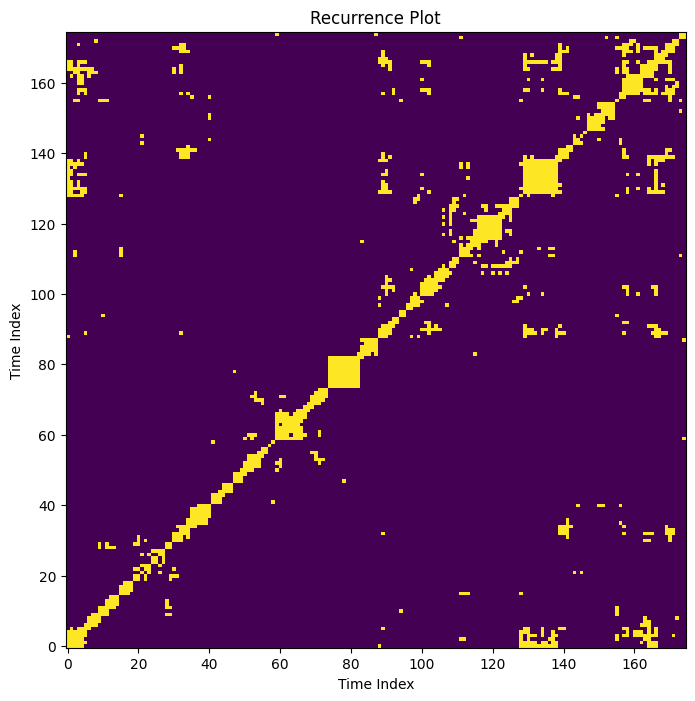

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [83]:
plot_recurrence_matrix(df_monolog['sentence_embeddings'][10])

In [10]:
# 3) Define a helper function to transform a single row's embeddings
#dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors_large_model'
import matplotlib.pyplot as plt
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/window_vectors/'
dir_array_utt='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'

pooling_method='mean'
if pooling_method=='max':
    ML=5
else:
    ML=3
    MLC=5
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=2
step_sparsities=[0]
dim_reduction=50
span=1
window=60
step=int(0.25*window)
df_monolog=df_monologs
df_name='SER_monologs'

with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
    embeds= pickle.load(f)
    if pooling_method=='max':
        embeds=[np.array(i) for i in embeds]
        
with open(f'{dir_array_utt}/utterance_{span}_{df_name}_{pooling_method}_backX_sentence_embeddings_arrays.pkl', 'rb') as f:
    embeds2= pickle.load(f)
if len(embeds)!=len(df_monolog):
    raise Exception('MISMATCH IN LENGTH')

df_monolog['sentence_embeddings'] = embeds


<IPython.core.display.Javascript object>


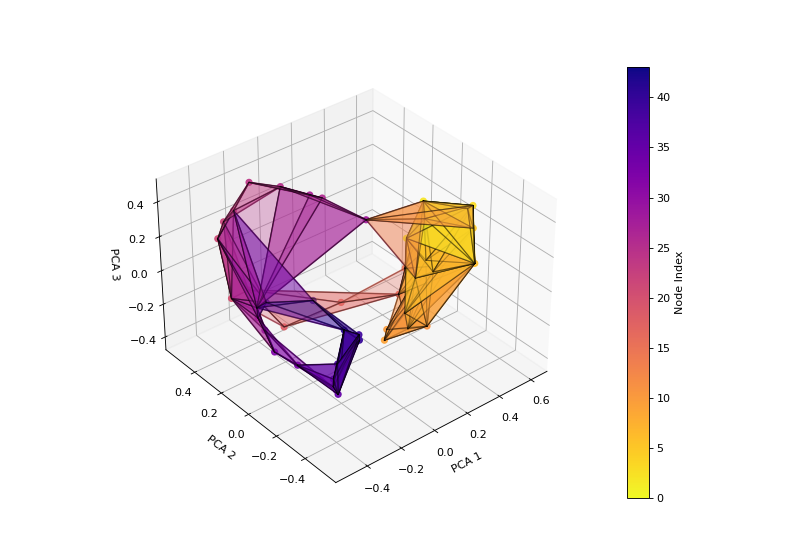

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib notebook
index=10
visualize_rips_simplicial_complex(embeds[index],'monolog',1,max_edge_length=1.1)
#visualize_rips_simplicial_complex(embeds2[index],'monolog',1,max_edge_length=1.5)

In [ ]:
# 3) Define a helper function to transform a single row's embeddings
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
pooling_method='mean'
if pooling_method=='max':
    ML=5
else:
    ML=3
    MLC=5
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=2
step_sparsities=[0]

df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
df_MASM=pd.read_csv(preprocessed_df_dir + '/MASM.csv')
df_DEI=pd.read_csv(preprocessed_df_dir + '/cleaned_DEI.csv')

print(f'using {pooling_method} pooling')
import gc
import shutil
from tqdm import tqdm
df_names=['SER_monologs','PEM_df', 'SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI']
dfs1=[df_monologs,df_PEM,  df_SER2, df_SER_MA, df_MASM, df_DEI]
if len(df_names)!=len(dfs1):
    raise Exception('MISMATCH IN NAMES/dfs') 
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
dim_reduction=50
for ss, span in enumerate([4,5]):
    step_sparsity=0#step_sparsities[ss]
    print('Step size:', step_sparsity)
    layers='last'
    dfs=dfs1.copy()
    for df_no, df_monolog in enumerate(dfs):

        df_name=df_names[df_no]
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
        data_save_dir_name=working_dir+f'TDA_output/{df_name}_{span}_{pooling_method}_{dim_reduction}/'
        if os.path.exists(data_save_dir_name):
            shutil.rmtree(data_save_dir_name)  # Deletes the entire directory and its contents
        os.makedirs(data_save_dir_name, exist_ok=True)

        with open(f'{dir_array}/utterance_{span}_{df_name}_{pooling_method}_back3_sentence_embeddings_arrays.pkl', 'rb') as f:
            embeds= pickle.load(f)
            if pooling_method=='max':
                embeds=[np.array(i) for i in embeds]
        newfilename=f'{df_name}_utterance_distance_results_{dim_reduction}.csv'
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds


        print(len(embeds))
        print(len(df_monolog))
        if len(embeds)!=len(df_monolog):
            raise Exception('MISMATCH IN LENGTH')

        df_monolog['sentence_embeddings'] = embeds
        df_monolog['length'] = [len(i) for i in embeds]
        if test_mode:
            df_monolog=df_monolog[0:10]
        df_monolog = df_monolog[
            df_monolog["sentence_embeddings"].apply(
                lambda x: (
                    not isinstance(x, float)               # exclude floats
                    and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                    and len(x) >= 3                        # length >= 3
                )
            )]

        # 4) Apply that function to each row -> produce a new column
        if reduce_dims:
            print('reducing dims')
            all_vecs = []
            for row in df_monolog['sentence_embeddings']:
                arr = np.array(row)  
                all_vecs.append(arr)
            big_matrix = np.concatenate(all_vecs, axis=0)
            pca = PCA(n_components=dim_reduction, svd_solver='full')
            pca.fit(big_matrix)
            def transform_embeddings(emb_list):
                emb_array = np.array(emb_list)   # shape (k_i, 384)
                emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                return emb_pca
            df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
          #  print(df_monolog['sentence_embeddings'].iloc[0])
            #         df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(
#             lambda x: increase_sparsity(x, skip=step_sparsity)
#         )
        df_monolog['token_embeddings']=None
        print('performing TDA on ',df_name, ' span: ', span)#, 'step: ', step)

        for fi in tqdm(range(0, len(df_monolog), chunk_size), desc="Processing Chunks"):
            if fi+chunk_size>=len(df_monolog):
                df_subset=df_monolog[fi:].reset_index(drop=True)
            else:
                df_subset=df_monolog[fi:fi+chunk_size].reset_index(drop=True)


           # drugs=list(set(df_subset['Drug']))
            #Participants=list(set(df_subset['Participant']))
            df_subset=get_rips_time(df_subset,embeddings=embeddings)
           # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
            #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')
            #print('got RIPS')
            df_with_graph=get_rips_complex_G(df_subset)
            #print('got G')
            #df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
            # Apply the function to each graph in df_with_graph
            graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
            graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
            df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                        # Create a new DataFrame

            # We'll accumulate new rows in a list of dicts
            new_rows = []
            dimensions = [0, 1, 2]

            for idx, row in df_with_graph.iterrows():
                embed = row[embeddings]  # Adjust as needed
                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }



                # Build the Rips Complex for *this row only*
                rips_complex =row['rips']
                try:
                    simplex_tree = \
                    rips_complex.create_simplex_tree(max_dimension=dims_simplex)
                except Exception as e:
                    continue
                persistence = simplex_tree.persistence()

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)


                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{span}_TDA_results.csv')
            del df_subset
            del df_with_graph
            gc.collect()
        print(f'completed! {df_name} span: {span}')
        list_files=sorted(os.listdir(data_save_dir_name))
        ddfs=[]
        for f in list_files:
            ddfs.append(pd.read_csv(data_save_dir_name+f))
        data=pd.concat(ddfs)
        data.to_csv(data_save_dir+f'{df_name}_{span}_{pooling_method}_{dim_reduction}_utterance_TDA_results.csv')

In [ ]:
for SP in [1,2,3]:
    for name in ['PEM_df','SER_IPSP','SER_monologs','MASM', 'cleaned_DEI']:
        data_save_dir=working_dir+'TDA_output/'
        data_save_dir_name=working_dir+f'TDA_output/{name}_{SP}_mean/'
        list_files=sorted(os.listdir(data_save_dir_name))
        dfs=[]
        for f in list_files:
            dfs.append(pd.read_csv(data_save_dir_name+f))
        data=pd.concat(dfs)
        data.to_csv(data_save_dir+f'{name}_{SP}_back_utterance_TDA_results.csv')
        print(name, len(data))

In [ ]:
# 3) Define a helper function to transform a single row's embeddings
ML=3
embeddings='sentence_embeddings'
reduce_dims=True
SPARSE=True
sparse_param=0.5
dims_simplex=3
chunk_size=5
df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM.csv')
df_SER_MA=pd.read_csv(f'{dir_atom_dfs}/SER1.csv')


In [5]:
import gc
import shutil
df_names=['PEM_df','SER_monologs', 'SER_IPSP', 'SER1']
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:
        
for overlap in [0.1]:
    for window in ['utterances']:
        layers='last'

        dfs=[df_PEM, df_monologs, df_SER2, df_SER_MA]

        for df_no, df_monolog in enumerate(dfs):

            df_name=df_names[df_no]
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
            data_save_dir_name=working_dir+f'TDA_output/{df_name}/'
            if os.path.exists(data_save_dir_name):
                shutil.rmtree(data_save_dir_name) 
            os.makedirs(data_save_dir_name, exist_ok=True)

            if window=='utterances':
                with open(f'{dir_array}/utterance_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds= pickle.load(f)   
                newfilename=f'{df_name}_utterance_distance_results.csv'

            else:
                step=int(window*overlap)#4
                with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                    embeds = pickle.load(f)   
                newfilename=f'{df_name}_{window}_{step}_distance_results.csv'
            
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')
                
            df_monolog['sentence_embeddings'] = embeds


            print(len(embeds))
            print(len(df_monolog))
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')

            df_monolog['sentence_embeddings'] = embeds
            df_monolog['length'] = [len(i) for i in embeds]
            if test_mode:
                df_monolog=df_monolog[0:10]
            df_monolog = df_monolog[
                df_monolog["sentence_embeddings"].apply(
                    lambda x: (
                        not isinstance(x, float)               # exclude floats
                        and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                        and len(x) >= 3                        # length >= 3
                    )
                )]

            # 4) Apply that function to each row -> produce a new column
            if reduce_dims:
                all_vecs = []
                for row in df_monolog['sentence_embeddings']:
                    arr = np.array(row)  
                    all_vecs.append(arr)
                big_matrix = np.concatenate(all_vecs, axis=0)
                pca = PCA(n_components=50)
                pca.fit(big_matrix)
                def transform_embeddings(emb_list):
                    emb_array = np.array(emb_list)   # shape (k_i, 384)
                    emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                    return emb_pca
                df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
            df_monolog['token_embeddings']=None
            print('performing TDA on ',df_name, ' window: ', window)#, 'step: ', step)
            
            for fi in range(0, len(df_monolog), chunk_size):
                
                if fi+chunk_size>=len(df_monolog):
                    df_subset=df_monolog[fi:].reset_index(drop=True)
                else:
                    df_subset=df_monolog[fi:fi+chunk_size].reset_index(drop=True)
                

                drugs=list(set(df_subset['Drug']))
                #Participants=list(set(df_subset['Participant']))
                df_subset=get_rips_time(df_subset,embeddings=embeddings)
               # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
                #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')
                print('got RIPS')
                df_with_graph=get_rips_complex_G(df_subset)
                print('got G')
                print(df_with_graph['graph'][0].nodes())
                #df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
                # Apply the function to each graph in df_with_graph
                graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)

                print(graph_metrics)
                graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
                df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                            # Create a new DataFrame

                # We'll accumulate new rows in a list of dicts
                new_rows = []
                dimensions = [0, 1, 2]

                for idx, row in df_with_graph.iterrows():
                    embed = row[embeddings]  # Adjust as needed
                    # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                    dim_dict = {
                        dim: {'births': [], 'deaths': [], 'pers': []}
                        for dim in dimensions
                    }



                    # Build the Rips Complex for *this row only*
                    rips_complex =row['rips']
                    try:
                        simplex_tree = \
                        rips_complex.create_simplex_tree(max_dimension=dims_simplex)
                    except Exception as e:
                        continue
                    persistence = simplex_tree.persistence()

                    # Collect intervals by dimension
                    for dim, (b, d) in persistence:
                        if d == float('inf'):
                            continue
                        if dim in dimensions:
                            dim_dict[dim]['births'].append(b)
                            dim_dict[dim]['deaths'].append(d)
                            dim_dict[dim]['pers'].append(d - b)


                    row_dict = row.to_dict()  # Start with original row's columns

                    for dim in dimensions:
                        bdp = dim_dict[dim]
                        stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                        # prefix each stat key with dim
                        for stat_key, stat_val in stats_dict.items():
                            row_dict[f"{stat_key}_dim{dim}"] = stat_val

                    # Add row_dict to new_rows
                    new_rows.append(row_dict)

                # Create a new DataFrame
                df_with_tda = pd.DataFrame(new_rows)
                if window=='utterances':
                    df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{window}_TDA_results.csv')
                else:
                    df_with_tda.to_csv(data_save_dir_name + f'{df_name}_{fi}_{window}_{step}_TDA_results.csv')
                print(f'completed! {df_name} window: {window}')
                del df_subset
                del df_with_graph
                gc.collect()

130
130
performing TDA on  PEM_df  window:  utterances
rips mem 0 285.8203125
simplex mem 346.5078125
persistence mem 402.87109375
rips max mem 402.87109375
rips mem 1 402.87109375
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 2 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 3 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
rips mem 4 432.5625
simplex mem 432.5625
persistence mem 432.5625
rips max mem 432.5625
got RIPS
got G
[0, 5, 7, 8, 18, 23, 28, 38, 39, 76, 43, 24, 37, 67, 55, 59, 66, 40, 58, 44, 77, 1, 2, 3, 4, 13, 27, 30, 31, 53, 60, 19, 61, 62, 63, 26, 68, 75, 33, 57, 29, 36, 71, 11, 12, 20, 21, 22, 64, 14, 10, 52, 25, 16, 46, 47, 81, 65, 17, 32, 35, 9, 56, 80, 42, 15, 69, 48, 70, 45, 54, 6, 78, 34, 72, 73, 74, 49, 51, 41, 79, 50]
0    {'shortest_path_unweighted': 2, 'nodes': 82, '...
1    {'shortest_path_unweighted': 2, 'nodes': 75, '...
2    {'shortest_path_unweighted': 1, 'nodes

persistence mem 654.16015625
rips max mem 654.16015625
rips mem 2 654.16015625
simplex mem 654.16015625
persistence mem 654.14453125
rips max mem 654.14453125
rips mem 3 654.14453125
simplex mem 654.14453125
persistence mem 654.14453125
rips max mem 654.14453125
rips mem 4 654.14453125
simplex mem 654.14453125
persistence mem 654.14453125
rips max mem 654.14453125
got RIPS
got G
[0, 4, 22, 23, 26, 27, 28, 30, 33, 37, 49, 53, 58, 59, 62, 66, 69, 75, 43, 79, 73, 52, 77, 32, 78, 1, 2, 3, 7, 9, 11, 18, 20, 21, 44, 45, 50, 57, 63, 64, 65, 68, 76, 46, 17, 13, 51, 6, 12, 16, 55, 56, 61, 72, 47, 54, 71, 81, 15, 14, 74, 60, 67, 70, 82, 80, 42, 19, 29, 5, 38, 10, 34, 31, 36, 8, 35, 48, 24, 39, 41, 40]
0    {'shortest_path_unweighted': 2, 'nodes': 82, '...
1    {'shortest_path_unweighted': 2, 'nodes': 68, '...
2    {'shortest_path_unweighted': 1, 'nodes': 89, '...
3    {'shortest_path_unweighted': 2, 'nodes': 17, '...
4    {'shortest_path_unweighted': 1, 'nodes': 59, '...
Name: graph, dtype: obje

KeyboardInterrupt: 

using max pooling


130
130
performing TDA on  PEM_df  span:  1


Processing Chunks:   0%|                                 | 0/26 [00:00<?, ?it/s]


TypeError: must be real number, not NoneType

In [11]:
SP=2
for name in ['PEM_df','SER_IPSP','SER_monologs','MASM', 'cleaned_DEI']:
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}_{SP}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_{SP}_back_utterance_TDA_results.csv')
    print(name, len(data))

PEM_df 130
SER_IPSP 107
SER_monologs 100
MASM 66
cleaned_DEI 73


In [29]:
df_names=['PEM_df','SER_monologs', 'SER_IPSP', 'SER1', 'MASM', 'cleaned_DEI']
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}_{1}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_{1}_utterance_TDA_results.csv')

PEM_df 130
SER_IPSP 107
SER_monologs 100
MASM 66
cleaned_DEI 73


In [29]:
for name in ['PEM_df','SER_monologs', 'SER_IPSP', 'SER1']:
    data_save_dir=working_dir+'TDA_output/'
    data_save_dir_name=working_dir+f'TDA_output/{name}/'
    list_files=sorted(os.listdir(data_save_dir_name))
    dfs=[]
    for f in list_files:
        dfs.append(pd.read_csv(data_save_dir_name+f))
    data=pd.concat(dfs)
    data.to_csv(data_save_dir+f'{name}_utterances_TDA_results.csv')

In [16]:
data_save_dir

'/home/ll16598/Documents/POSTDOC/TDA_output/'

In [ ]:
data_save_dir_name=working_dir+f'TDA_output/{df_name}/'
os.makedirs(data_save_dir_name, exist_ok=True)

df_monolog['token_embeddings']=None
print('performing TDA on ',df_name, ' window: ', window, 'step: ', step)

for fi in range(0, len(df_monolog), chunk_size):

    if fi+chunk_size>=len(df_monolog):
        df_subset=df_monolog[fi:]
    else:
        df_subset=df_monolog[fi:fi+chunk_size]

    df_subset=get_rips_time(df_subset,embeddings=embeddings)
    df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
    print('completed rips')
    df_subset=get_simplices_over_time(df_subset,simplex_tree_type='simplex_tree')
    for D in [2, 3, 4]:
        # Explode the lists in the columns for the current dimension.
        try:
            df_exploded = df_subset.explode([f"simplex_time_dim{D}_filtration", f"simplex_time_dim{D}_count"])
        except Exception as e:
            continue
       # Convert the exploded columns to numeric.
        df_exploded[f"simplex_time_dim{D}_filtration"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_filtration"])
        df_exploded[f"simplex_time_dim{D}_count"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_count"])

        # Group by "Drug" and the filtration values, and compute the mean and standard error for the counts.
        grouped = df_exploded.groupby(["Drug", f"simplex_time_dim{D}_filtration"], as_index=False).agg(
            alive_mean=(f"simplex_time_dim{D}_count", "mean"),
            alive_se=(f"simplex_time_dim{D}_count", sem)  # standard error
        )
        if save:
            df_exploded.to_csv(data_save_dir_name + f'{fi}_{df_name}_{window}_{step}_{D}_skeleton_simplices_over_time.csv', index=False)


        if plot:
            import matplotlib.pyplot as plt
            # Create a plot for the current dimension.
            fig, ax = plt.subplots(figsize=(8, 6))

            # Iterate over each drug group and plot mean ± SE.
            for drug_level, df_sub in grouped.groupby("Drug"):
                ax.errorbar(
                    df_sub[f"simplex_time_dim{D}_filtration"],
                    df_sub["alive_mean"],
                    yerr=df_sub["alive_se"],
                    label=f"Drug={drug_level}",
                    marker='o',
                    capsize=3
                )

            ax.set_xlabel("Filtration Value (Distance Threshold)")
            ax.set_ylabel("Number of Alive Components (Mean ± SE)")
            ax.set_title(f"Dimension {D} Alive Components Over Filtration Value by Drug")
            ax.legend()
            plt.show()

    for D in [0,1,2]:
        df_exploded = df_subset.explode([f"scales_dim{D}", f'alive_dim{D}'])
        df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
        df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
        grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
            alive_mean=(f'alive_dim{D}', "mean"),
            alive_se=(f'alive_dim{D}', sem)  # standard error
        )
        df_exploded.to_csv(data_save_dir_name+f'{fi}_{df_name}_{window}_{step}_{D}_simplices_over_time.csv')
        if plot:

            fig, ax = plt.subplots(figsize=(8,6))

            # We'll iterate over each drug and plot mean ± SE
            for drug_level, df_sub in grouped.groupby("Drug"):
                ax.errorbar(
                    df_sub[f"scales_dim{D}"], 
                    df_sub["alive_mean"], 
                    yerr=df_sub["alive_se"], 
                    label=f"Drug={drug_level}",
                    marker='o',
                    capsize=3
                )

            ax.set_xlabel("Scale (distance threshold)")
            ax.set_ylabel("Number of Alive Components (Mean ± SE)")
            ax.set_title("Connected Components Over Scale by Drug")
            ax.legend()
            plt.show()

    df_with_graph=get_rips_complex_G(df_subset)
    #df_with_graph['euler'] = df_with_graph['rt_rips'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
    # Apply the function to each graph in df_with_graph
    graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
    graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
    df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)



    dimensions = [0, 1, 2]

    # We'll accumulate new rows in a list of dicts
    new_rows = []

    for idx, row in df_subset.iterrows():
        embed = row[embeddings]  # Adjust as needed
        # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
        dim_dict = {
            dim: {'births': [], 'deaths': [], 'pers': []}
            for dim in dimensions
        }



        # Build the Rips Complex for *this row only*
        rips_complex =row['rips']
        try:
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=dims_simplex)
        except Exception as e:
            continue
        persistence = simplex_tree.persistence()

        # Collect intervals by dimension
        for dim, (b, d) in persistence:
            if d == float('inf'):
                continue
            if dim in dimensions:
                dim_dict[dim]['births'].append(b)
                dim_dict[dim]['deaths'].append(d)
                dim_dict[dim]['pers'].append(d - b)


        row_dict = row.to_dict()  # Start with original row's columns

        for dim in dimensions:
            bdp = dim_dict[dim]
            stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
            # prefix each stat key with dim
            for stat_key, stat_val in stats_dict.items():
                row_dict[f"{stat_key}_dim{dim}"] = stat_val

        # Add row_dict to new_rows
        new_rows.append(row_dict)

    # Create a new DataFrame
    print('completed',f'{df_name}_{window}_{step}')
    df_with_tda = pd.DataFrame(new_rows)
    if reduce_dims:
        df_with_tda.to_csv(data_save_dir_name + f'{fi}_D50_{SP}{df_name}_{window}_{step}_TDA_results.csv')
    else:
        df_with_tda.to_csv(data_save_dir_name + f'{fi}_{SP}{df_name}_{window}_{step}_TDA_results.csv')
    print(f'completed! {df_name} window: {window} step size: {step}')

In [ ]:

df_names=['SER_monologs', 'PEM_df', 'SER_IPSP', 'SER1']
data_save_dir=working_dir+'TDA_output/'
os.makedirs(data_save_dir, exist_ok=True)

completed_files=os.listdir(data_save_dir)
# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:

# for overlap in [0.1,0.2,0.4]:
#     for window in [60,80,100,120,140,160,180,200]:
        
for overlap in [0.1]:
    for window in [100]:
        step=int(window*overlap)#4
        layers='last'

        dfs=[df_monologs, df_PEM, df_SER2, df_SER_MA]

        for df_no, df_monolog in enumerate(dfs):

            df_name=df_names[df_no]
            newfilename=f'{df_name}_{window}_{step}_TDA_results.csv'
#             if newfilename in completed_files:
#                 print(f'Already completed {newfilename}')
#                 continue
        
            with open(f'{dir_array}/{window}_{step}_{df_name}_sentence_embeddings_arrays.pkl', 'rb') as f:
                embeds = pickle.load(f)
            
            df_monolog['sentence_embeddings'] = embeds


            print(len(embeds))
            print(len(df_monolog))
            if len(embeds)!=len(df_monolog):
                raise Exception('MISMATCH IN LENGTH')

            df_monolog['sentence_embeddings'] = embeds
            df_monolog['length'] = [len(i) for i in embeds]
            if test_mode:
                df_monolog=df_monolog[0:10]
            df_monolog = df_monolog[
                df_monolog["sentence_embeddings"].apply(
                    lambda x: (
                        not isinstance(x, float)               # exclude floats
                        and isinstance(x, (list, tuple, np.ndarray))  # must be list/tuple/np.ndarray
                        and len(x) >= 3                        # length >= 3
                    )
                )]

            # 4) Apply that function to each row -> produce a new column
            if reduce_dims:
                all_vecs = []
                for row in df_monolog['sentence_embeddings']:
                    arr = np.array(row)  
                    all_vecs.append(arr)
                big_matrix = np.concatenate(all_vecs, axis=0)
                pca = PCA(n_components=50)
                pca.fit(big_matrix)
                def transform_embeddings(emb_list):
                    emb_array = np.array(emb_list)   # shape (k_i, 384)
                    emb_pca = pca.transform(emb_array)  # shape (k_i, 50)
                    return emb_pca
                df_monolog['sentence_embeddings'] = df_monolog['sentence_embeddings'].apply(transform_embeddings)
            df_monolog['token_embeddings']=None
            print('performing TDA on ',df_name, ' window: ', window, 'step: ', step)

            for fi in range(0, len(df_monolog), chunk_size):
                
                if fi+chunk_size>=len(df_monolog):
                    df_subset=df_monolog[fi:]
                else:
                    df_subset=df_monolog[fi:fi+chunk_size]
                

                drugs=list(set(df_subset['Drug']))
                Participants=list(set(df_subset['Participant']))
                df_subset=get_rips_time(df_subset,embeddings=embeddings)
               # df_subset=get_rips_time_centroid(df_subset,embeddings=embeddings)
                #df_monolog=get_simplices_over_time(df_monolog,simplex_tree_type='simplex_tree')

                df_with_graph=get_rips_complex_G(df_subset)
                df_with_graph['euler'] = df_with_graph['rt_simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=4))
                # Apply the function to each graph in df_with_graph
                graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)
                print(graph_metrics)
                graph_metrics_df = pd.DataFrame(graph_metrics.tolist())
                df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)
                            # Create a new DataFrame
                df_with_graph.to_csv(data_save_dir + f'{df_name}_{fi}_{window}_{step}_TDA_results.csv')
                df_subset=None
                df_with_graph=None
                print(f'completed! {df_name} window: {window} step size: {step}')

In [ ]:
def get_rips_time(df, embeddings='sentence_embeddings', step=0.025):
    """
    For each row in df, build a Rips complex, extract dimension-D intervals
    (e.g., D=0 => connected components, D=1 => loops, etc.),
    then compute how many such features are 'alive' at increments of 'step'.

    Creates two new columns in df:
    - f"scales_dim{D}": The scale values
    - f"alive_dim{D}": The counts of alive features at each scale
    """
    # Copy the DataFrame to avoid SettingWithCopy warnings
    df = df.copy()
    
    # Prepare two new columns (lists)
    df[f'scales_dim0'] = None
    df[f'alive_dim0'] = None
    df[f'scales_dim1'] = None
    df[f'alive_dim1'] = None
    df[f'scales_dim2'] = None
    df[f'alive_dim2'] = None
    df['rt'] = None
    df['simplex_tree']=None
    df["rt_rips"]=None
    
    for idx, row in df.iterrows():
        # Get the embeddings for this row
        embed = row[embeddings]
        if not isinstance(embed, (list, np.ndarray)) or len(embed) == 0:
            continue
        
        # Build the Rips Complex
        rips_complex = gd.RipsComplex(points=embed, max_edge_length=3)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=dims_simplex)

        # Extract dimension-D intervals from persistence
        persistence = simplex_tree.persistence()
        for D in [0,1,2]:
            births_dimD = []
            deaths_dimD = []

            for dim, (b, d) in persistence:
                if dim == D and d != float('inf'):  # ignoring infinite intervals
                    births_dimD.append(b)
                    deaths_dimD.append(d)

            # Compute how many features are alive at each scale
            scales, alive_components = get_alive_components_over_scales(births_dimD, deaths_dimD, step=step)
            if len(deaths_dimD)>0:
                df.at[idx, f"rt"] = max(deaths_dimD)

            # Store these lists in the new columns
            df.at[idx, f"scales_dim{D}"] = scales
            df.at[idx, f"alive_dim{D}"] = alive_components
        try:
            rips_complex_max = gd.RipsComplex(points=embed, max_edge_length=df["rt"].loc[idx])
        except Exception as e:
            print(idx, df["rt"].loc[idx], embed)
        simplex_tree_max = rips_complex.create_simplex_tree(max_dimension=dims_simplex)
        df.at[idx, f"simplex_tree"] = simplex_tree
        df.at[idx, f"rt_simplex_tree"] = simplex_tree_max
        df.at[idx, f"rt_rips"] = rips_complex_max

    return df

In [ ]:
def visualize_rips_simplicial_complex(rt_rips, simp_tree, dataset_name, entry, max_edge_length=5.0,SAVE=False):
    """
    1) Builds a Rips complex (via GUDHI) from a set of high-dimensional points.
    2) Extracts simplices (up to dimension 2) from the simplex tree.
       - Edges (1-simplices) and triangles (2-simplices).
    3) Uses PCA to reduce the points to 3D.
    4) Plots a 3D visualization:
       - Nodes are shown as a scatter plot.
       - Edges are drawn as lines.
       - Triangles are drawn as filled polygons (using Poly3DCollection).
    
    Parameters:
    -----------
    embed : np.ndarray of shape (N, D)
        The high-dimensional point cloud.
    max_edge_length : float
        The maximum edge length used in the Rips complex.
    """
#     # 1) Build the Rips complex and create the simplex tree
#     rips_complex = gd.RipsComplex(points=embed, max_edge_length=max_edge_length)
    simplex_tree = rt_rips.create_simplex_tree(max_dimension=5)
    
#     # 2) Extract simplices:
    edges = []
    triangles = []
    
    # get_skeleton(2) returns all simplices up to dimension 2
    for simplex, fvalue in simplex_tree.get_skeleton(4):
        if len(simplex) == 2:
            # 1-simplices: edges
            edges.append(simplex)
        elif len(simplex) == 3:
            # 2-simplices: triangles
            triangles.append(simplex)
    G=nx.Graph()        
    for simplex, fvalue in simplex_tree.get_skeleton(4):
        if len(simplex) >= 2:
            for (i, j) in itertools.combinations(simplex, 2):
                G.add_edge(i, j, weight=fvalue)
    metrics=compute_graph_metrics(G)
    print(metrics)
    # 3) Use PCA to reduce the point cloud to 3D
    pca = PCA(n_components=3)
    coords_3d = pca.fit_transform(embed)  # shape (N, 3)
    n_points = coords_3d.shape[0]
    
    # Prepare colormap for nodes (using 'magma_r')
    norm = plt.Normalize(vmin=0, vmax=n_points - 1)
    cmap = plt.get_cmap('plasma_r')
    node_colors = cmap(norm(np.arange(n_points)))
    
    # 4) Create the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes
    sc = ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2],
                    c=node_colors, s=30, alpha=0.9)
    
    # Plot edges as lines
    for edge in edges:
        i, j = edge
        x_vals = [coords_3d[i, 0], coords_3d[j, 0]]
        y_vals = [coords_3d[i, 1], coords_3d[j, 1]]
        z_vals = [coords_3d[i, 2], coords_3d[j, 2]]
        # Optionally, color edge based on one endpoint's index or the average.
        avg_idx = int(np.mean(edge))
        edge_color = cmap(norm(avg_idx))
        ax.plot(x_vals, y_vals, z_vals, color=edge_color, alpha=0.8, linewidth=1.5)
    
    # Plot triangles as filled faces
    face_polys = []
    face_colors = []
    for tri in triangles:
        # Get the 3 vertices for this triangle
        pts = [coords_3d[idx] for idx in tri]
        face_polys.append(pts)
        # Color can be computed from the average index of the triangle's vertices
        avg_idx = int(np.mean(tri))
        face_colors.append(cmap(norm(avg_idx)))
    
    # Create a Poly3DCollection for the triangles with a set transparency (alpha)
    poly_collection = Poly3DCollection(face_polys, alpha=0.3, edgecolor='k')
    poly_collection.set_facecolor(face_colors)
    ax.add_collection3d(poly_collection)
    
    # Set title and labels
    ax.set_title(f"", pad=20)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    
    # Add colorbar for node indices
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label("Node Index")
        # Define three different viewing angles
    angles = [(15, 180), (30, 90), (45, 0)]  # (elevation, azimuth) in degrees
    dir_fig_save=working_dir+f'rips_skeletons/{dataset_name}_{window}_{step}/'
    os.makedirs(dir_fig_save, exist_ok=True)

    # Save figures from different angles
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)  # Set camera angle
        filename = dir_fig_save+f"{entry}_{i}.png"
        if SAVE:
            plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save figure
       # print(f"Saved: {filename}")

    #plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
idx=2
embed=df_with_graph['sentence_embeddings'][idx]
simp_tre=df_with_graph['rt_rips'][idx]
rt=df_with_graph['rt'][idx]
visualize_rips_simplicial_complex(simp_tre, embed, 'x', 1, max_edge_length=rt,SAVE=False)


In [8]:

            
            # Assuming df_monolog is your DataFrame and data_save_dir, df_name, window, and step are defined.
            # For each dimension (2, 3, 4) we explode the corresponding columns and then group by Drug and filtration values.

            for D in [2, 3, 4]:
                # Explode the lists in the columns for the current dimension.
                df_exploded = df_monolog.explode([f"simplex_time_dim{D}_filtration", f"simplex_time_dim{D}_count"])

                # Convert the exploded columns to numeric.
                df_exploded[f"simplex_time_dim{D}_filtration"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_filtration"])
                df_exploded[f"simplex_time_dim{D}_count"] = pd.to_numeric(df_exploded[f"simplex_time_dim{D}_count"])

                # Group by "Drug" and the filtration values, and compute the mean and standard error for the counts.
                grouped = df_exploded.groupby(["Drug", f"simplex_time_dim{D}_filtration"], as_index=False).agg(
                    alive_mean=(f"simplex_time_dim{D}_count", "mean"),
                    alive_se=(f"simplex_time_dim{D}_count", sem)  # standard error
                )
                if save:
                    df_exploded.to_csv(data_save_dir + f'{df_name}_{window}_{step}_{D}_skeleton_simplices_over_time.csv', index=False)


                if plot:
                    import matplotlib.pyplot as plt
                    # Create a plot for the current dimension.
                    fig, ax = plt.subplots(figsize=(8, 6))

                    # Iterate over each drug group and plot mean ± SE.
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"simplex_time_dim{D}_filtration"],
                            df_sub["alive_mean"],
                            yerr=df_sub["alive_se"],
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Filtration Value (Distance Threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title(f"Dimension {D} Alive Components Over Filtration Value by Drug")
                    ax.legend()
                    plt.show()

            for D in [0,1,2]:
                df_exploded = df_monolog.explode([f"scales_dim{D}", f'alive_dim{D}'])
                df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
                df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
                grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
                    alive_mean=(f'alive_dim{D}', "mean"),
                    alive_se=(f'alive_dim{D}', sem)  # standard error
                )
                df_exploded.to_csv(data_save_dir+f'{df_name}_{window}_{step}_{D}_simplices_over_time.csv')
                if plot:

                    fig, ax = plt.subplots(figsize=(8,6))

                    # We'll iterate over each drug and plot mean ± SE
                    for drug_level, df_sub in grouped.groupby("Drug"):
                        ax.errorbar(
                            df_sub[f"scales_dim{D}"], 
                            df_sub["alive_mean"], 
                            yerr=df_sub["alive_se"], 
                            label=f"Drug={drug_level}",
                            marker='o',
                            capsize=3
                        )

                    ax.set_xlabel("Scale (distance threshold)")
                    ax.set_ylabel("Number of Alive Components (Mean ± SE)")
                    ax.set_title("Connected Components Over Scale by Drug")
                    ax.legend()
                    plt.show()
            

            dimensions = [0, 1, 2]

            # We'll accumulate new rows in a list of dicts
            new_rows = []

            for idx, row in df_with_graph.iterrows():
                embed = row[embeddings]  # Adjust as needed
                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }

                
                    
                # Build the Rips Complex for *this row only*
                rips_complex = gd.RipsComplex(points=embed, max_edge_length=5.0)
                simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
                persistence = simplex_tree.persistence()

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)
                        
                        
                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir + f'{df_name}_{window}_{step}_TDA_results.csv')
            print(f'completed! {df_name} window: {window} step size: {step}')

performing TDA on  SER_IPSP  window:  120 step:  24
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyError: 'simplex_time_dim2_filtration'